# Steps to finish the work
- Business Understanding
- Data Summary
- Data Cleaning
- Correlation Analysis
- Feature Engineering
- Modeling

## Business Understanding

BikeSharing is really a good supplement to the transportation system nowdays. The project will predict the number of bikes used during a certain hour on a certain day, including register and nonregister, according to the information, such as season, whether working day, temperature, humidity, windspeed, and something else.

## Data Summary

In [271]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

from sklearn.linear_model import (LinearRegression, Ridge, Lasso)
from sklearn.svm import SVR
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor)

from sklearn.model_selection import (KFold, GridSearchCV)
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

### Shape of training dataset

In [30]:
train = pd.read_csv('./train.csv')
train.shape

(10886, 12)

### Examples of training dataset

In [5]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


### Data type of training dataset

In [8]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

Actually, the value of season, holiday, workingday, and weather is discrete and represented by numeric data. The numeric data is suitable in modeling while the discrete data is good for correlation analysis. Thus, the project will transform the four features as catogerical data in correlation analysis. 

# Data Cleaning
- duplicate data
- outliers
- missing value

## Duplicate data

In [9]:
train.drop_duplicates()
train.shape

(10886, 12)

There is no duplicate data.

## Outliers

In [31]:
count_mean = train['count'].mean()
count_std = train['count'].std()
train = train[np.abs(train['count'] - count_mean) < (3 * count_std)]
train.shape

(10739, 12)

# Correlation Analysis

### Data discretization

- Map season from (1, 2, 3, 4) to (Spring, Summer, Fall, Winter)
- Map holiday from (0, 1) to (Nonholiday, Holiday)
- Map workingday from (0, 1) to (Workingday, Nonworkingday)

Actually, we should also map weather to categorical data, however, the name of weather is too long to understand easily. Thus, I still use numeric data for weather.

In [32]:
train['season'] = train['season'].map({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})
train['holiday'] = train['holiday'].map({1:'Holiday', 0:'Nonholiday'})
train['workingday'] = train['workingday'].map({1:'Workingday', 0:'Nonworkingday'})

### Creating features
- month
- day
- hour
- weekday

In [122]:
train['month'] = train['datetime'].apply(lambda x: x[5:7]).astype(int)
train['day'] = train['datetime'].apply(lambda x: x[8:10]).astype(int)
train['hour'] = train['datetime'].apply(lambda x: x[11:13]).astype(int) + 1

train['weekday'] = train['datetime'].apply(lambda x: datetime.strptime(x[0:10], '%Y-%m-%d').weekday() + 1)

train.head(3)

6    1582
7    1578
1    1528
4    1517
3    1514
5    1510
2    1510
Name: weekday, dtype: int64

### Correlation of each two features with continuous data

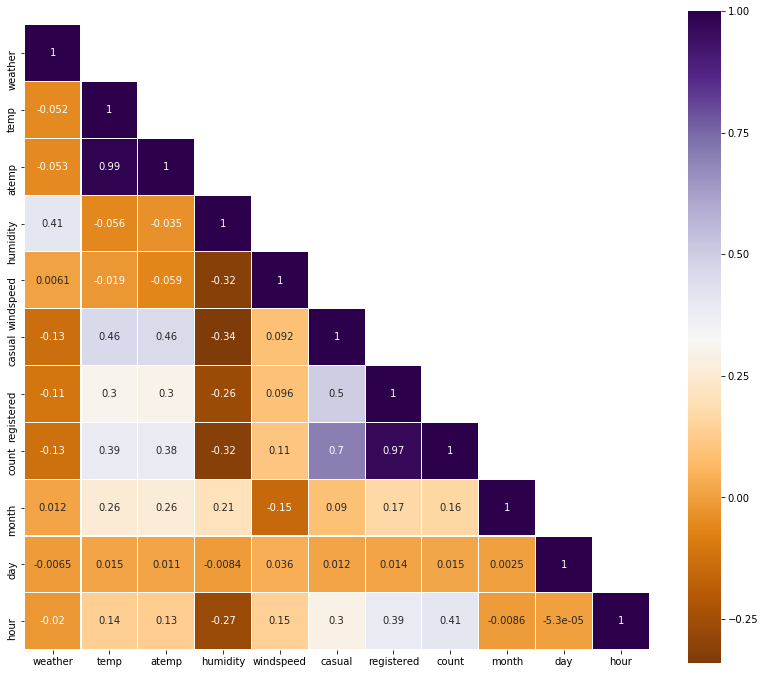

In [45]:
plt.figure(figsize=(14,12))
mask = np.array(train.corr())
mask[np.tril_indices(mask.shape[1])] = 0
sns.heatmap(train.corr(), linewidths=0.1, square=True, cmap=plt.cm.PuOr, linecolor='white', annot=True, mask=mask)

From the heatmap for correlaion of each two features, we can get some points:
- The correlation of 'temp' and 'atemp' is 0.99, which means these two features are highly dependent, so I will choose only one from them.
- The correlations of 'day' and each other features are all located between -0.1 and 0.1, so it has little influence in 'count'. It also prove that it is reasonable to predict the 'count' of 20th and later days by using data from 1st to 19th of each month.

### Visualize count vs. features with discrete data

      holiday       count
0     Holiday  185.877814
1  Nonholiday  182.918105


[Text(0,0.5,'Count'),
 Text(0.5,0,'Weather'),
 Text(0.5,1,'Average Count By Weather')]

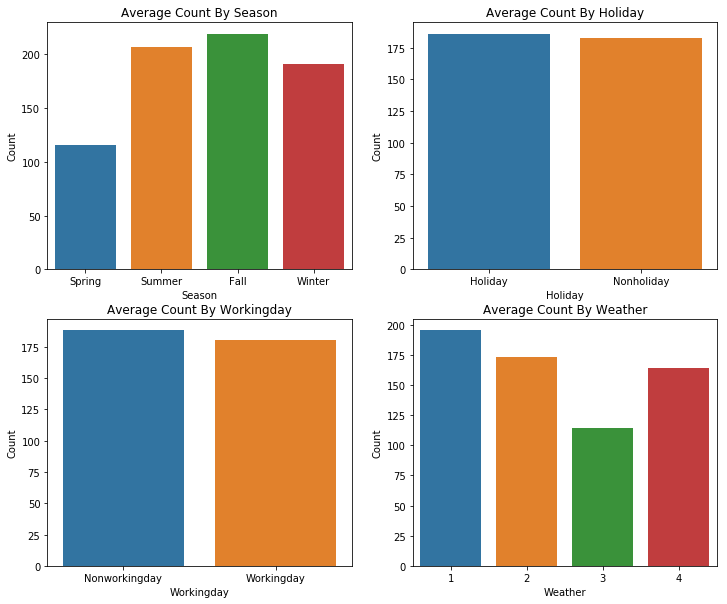

In [84]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)

dat_season = train[['season', 'count']].groupby(by='season').mean().reset_index()
sns.barplot(data=dat_season, x='season', y='count', order=['Spring', 'Summer', 'Fall', 'Winter'], ax=axes[0][0])
axes[0][0].set(title='Average Count By Season', xlabel='Season', ylabel='Count')

dat_holiday = train[['holiday', 'count']].groupby(by='holiday').mean().reset_index()
sns.barplot(data=dat_holiday, x='holiday', y='count', ax=axes[0][1])
axes[0][1].set(title='Average Count By Holiday', xlabel='Holiday', ylabel='Count')

dat_working = train[['workingday', 'count']].groupby(by='workingday').mean().reset_index()
sns.barplot(data=dat_working, x='workingday', y='count', ax=axes[1][0])
axes[1][0].set(title='Average Count By Workingday', xlabel='Workingday', ylabel='Count')

dat_weather = train[['weather', 'count']].groupby(by='weather').mean().reset_index()
sns.barplot(data=dat_weather, x='weather', y='count', ax=axes[1][1])
axes[1][1].set(title='Average Count By Weather', xlabel='Weather', ylabel='Count')

Takeaways:
- The count in summer and fall is higher than that in winter and, especially, spring.
- The difference between counts on holiday and nonholiday is similar to that on nonworkingday and workingday.
- With the weather goes bad, the count decreses but not fitting in the worst one.

### Visualize count vs. features with continuous data

[Text(0,0.5,'Average count'),
 Text(0.5,0,'Hour'),
 Text(0.5,1,'Average Count By hour across weekday')]

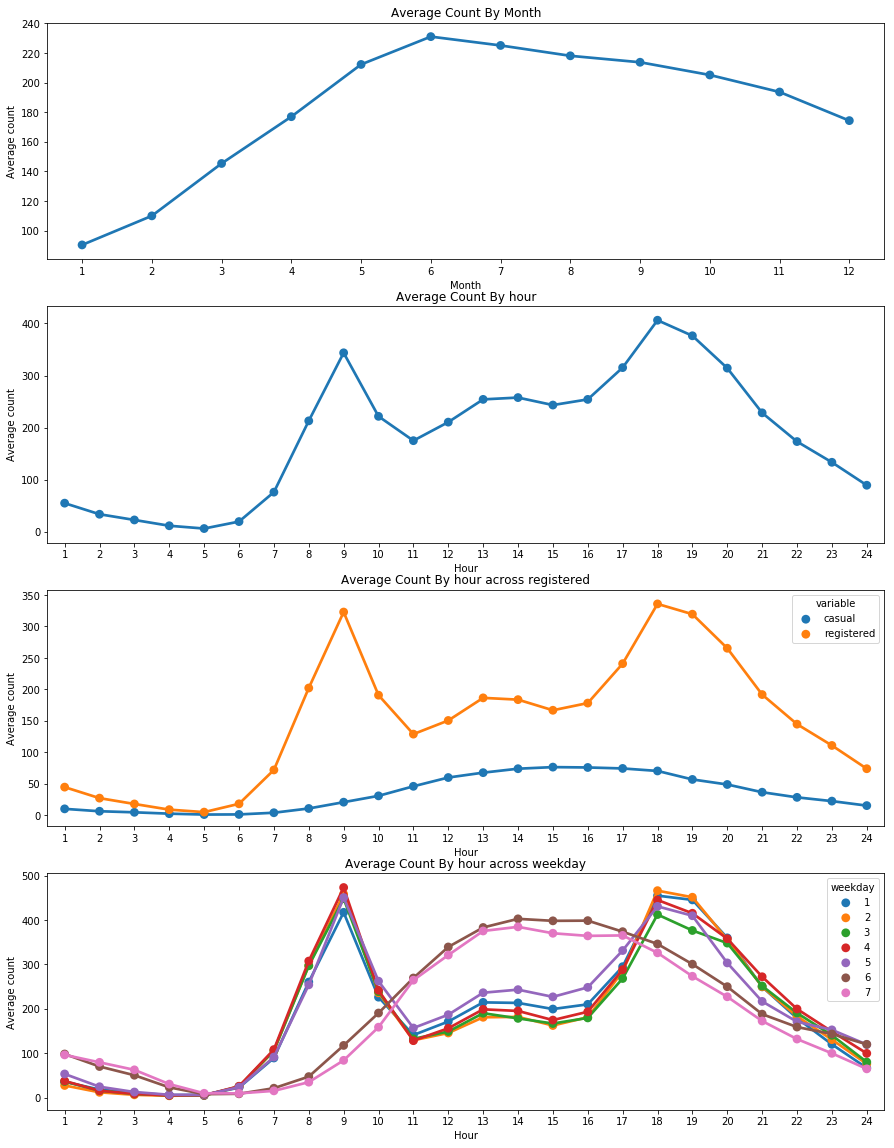

In [125]:
fig, axes = plt.subplots(nrows=4, ncols=1)
fig.set_size_inches(15,20)

dat_month = train[['month','count']].groupby(by='month').mean().reset_index()
sns.pointplot(data=dat_month, x='month', y='count', ax=axes[0])
axes[0].set(title='Average Count By Month', xlabel='Month', ylabel='Average count')

dat_hour = train[['hour','count']].groupby(by='hour').mean().reset_index()
sns.pointplot(data=dat_hour, x='hour', y='count', ax=axes[1])
axes[1].set(title='Average Count By hour', xlabel='Hour', ylabel='Average count')

dat_1 = pd.melt(train, id_vars='hour', value_vars=['registered','casual'])
dat_hour_register = dat_1.groupby(by=['hour','variable']).mean().reset_index()
sns.pointplot(data=dat_hour_register, x='hour', y='value', hue='variable', ax=axes[2])
axes[2].set(title='Average Count By hour across registered', xlabel='Hour', ylabel='Average count')

dat_hour_weekday = train[['hour', 'weekday', 'count']].groupby(by=['hour','weekday']).mean().reset_index()
sns.pointplot(data=dat_hour_weekday, x='hour', y='count', hue='weekday', ax=axes[3])
axes[3].set(title='Average Count By hour across weekday', xlabel='Hour', ylabel='Average count')

Takeaways:
- The count increases from Jan. to June and decreases after that, which is in accordance with the information revealed in 'Average count by season'.
- The count during 8:00-9:00 AM and 5:00-7:00 PM reaches the highest point in the day, which can be attributed to regular school and office commuters.
- The line of registered is in accordance with that of whole count while the line of casual is more smooth.
- The line of weekdays is same with that of whole count while the line of weekends is totally different.

# Feature Engineering

In [284]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
full = [train, test]

In [285]:
for dataset in full:
    dataset['hour'] = dataset['datetime'].apply(lambda x:x[11:13]).astype(int)
    dataset['weekday'] = dataset['datetime'].apply(lambda x:datetime.strptime(x[0:10],'%Y-%m-%d').weekday() + 1)
    dataset['month'] = dataset['datetime'].apply(lambda x:x[5:7]).astype(int)

In [286]:
train = train.drop(columns=['datetime','temp','casual','registered'])
x_train = train.drop(columns='count').values
y_train = train['count'].values
x_train.shape[0]

10886

In [287]:
datetime = test['datetime']
test = test.drop(columns=['datetime','temp'])
x_test = test.values
x_test.shape

(6493, 10)

I will replace count with its log value, since count is non-negative in real world and the regression model may have negative prediction which is meaningless.

In [288]:
y_train = np.log(y_train)
y_train

array([2.77258872, 3.68887945, 3.4657359 , ..., 5.12396398, 4.8598124 ,
       4.47733681])

# Modeling
## Build KFold

In [266]:
def scores(y_true, y_pred):
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
    y_true = np.log(y_true + 1)
    y_pred = np.log(y_pred + 1)
    sqr = np.square(y_true - y_pred)
    res = np.sqrt(sqr.mean())
    if res<0:
        print('error')
    return res

scorer = metrics.make_scorer(scores, greater_is_better=False)

def kfolder(reg, x_train, y_train):
    k = 5
    kfold = KFold(n_splits=k, random_state=0)
    y_pred = np.zeros(x_train.shape[0])
    for train_index, test_index in kfold.split(x_train):
        xt = x_train[train_index]
        yt = y_train[train_index]
        
        reg.fit(xt, yt)
        xv = x_train[test_index]
        
        y_pred[test_index] = reg.predict(xv)
    return scores(y_train, y_pred)

## Models
- Linear regression
- Ridge regression
- Lasso regression
- SVM
- Random Forest
- Gradient Boost

In [277]:
regression_list = []
regression_list.append(LinearRegression())

In [278]:
ridge = Ridge()
params = {'alpha':[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,100,1000,10000]}
r_cv = GridSearchCV(estimator=ridge, param_grid=params, scoring=scorer, refit=True)
r_cv.fit(x_train, y_train)
ridge = r_cv.best_estimator_
regression_list.append(ridge)

In [279]:
lasso = Lasso()
params = {'alpha':[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,100,1000,10000]}
l_cv = GridSearchCV(estimator=ridge, param_grid=params, scoring=scorer, refit=True)
l_cv.fit(x_train, y_train)
lasso = l_cv.best_estimator_
regression_list.append(lasso)

In [280]:
svr = SVR()
params = {'C':[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,100,1000,10000]}
s_cv = GridSearchCV(estimator=svc, param_grid=params, scoring=scorer, refit=True)
s_cv.fit(x_train, y_train)
svc = s_cv.best_estimator_
s_cv.best_score_
regression_list.append(svr)

In [281]:
rfr = RandomForestRegressor()
regression_list.append(rfr)

In [282]:
gbr = GradientBoostingRegressor()
params = {'n_estimators':[80,90,100,110,120,130],'learning_rate':[0.01,0.03,0.1,0.3,1,3]}
g_cv = GridSearchCV(estimator=gbr, param_grid=params, scoring=scorer)
g_cv.fit(x_train, y_train)
gbr = g_cv.best_estimator_
g_cv.best_score_
regression_list.append(gbr)

In [283]:
rmsle_dic = {}
for rgr in regression_list:
    rmsle = kfolder(rgr, x_train, y_train)
    rmsle_dic[rgr.__class__.__name__] = rmsle
rmsle_dic

{'GradientBoostingRegressor': 0.58254734589533,
 'LinearRegression': 1.0963790081676568,
 'RandomForestRegressor': 0.601970448017074,
 'Ridge': 1.0916996014472569,
 'SVR': 1.0810729322490602}

In [291]:
y_pred = gbr.predict(x_test)
y_pred = np.exp(y_pred)
y_pred.shape
submission = pd.DataFrame({'datetime':datetime,
                          'count':y_pred})
submission.to_csv('submission.csv', index=False)